# EDA Données Scraping TV et Webpress

Les données sont divisées en deux catégories : TV et Webpress.

TV :
- BFMTV
- FranceTvInfo

Webpress :
- 20 Minutes
- Le Point
- Le Figaro
- Le Monde
- L'Express
- Libération
- Nouvel Obs

Les Fichiers sont au format Parquet.

In [1]:
base_path = '../data_public/sitemap_dumps/'

# Import des librairies
import pandas as pd
import pyarrow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# créer deux listes contenant les noms des fichiers scrappés
tv_sources = os.listdir(base_path+'media_type=tv')
webpress_sources = os.listdir(base_path+'media_type=webpress')
filelist_tv = []
for source in tv_sources:
    for root, dirs, files in os.walk(base_path+'media_type=tv/'+source):
	    for file in files:
            #append the file name to the list
		    filelist_tv.append(os.path.join(root,file))

filelist_webpress = []
for source in webpress_sources:
    for root, dirs, files in os.walk(base_path+'media_type=webpress/'+source):
        for file in files:
            #append the file name to the list
            filelist_webpress.append(os.path.join(root,file))


In [2]:
#  Importer les fichiers parquet dans un dataframe pandas
df_tv = pd.DataFrame()
for file in filelist_tv:
    df_tv = df_tv.append(pd.read_parquet(file, engine='pyarrow'))

df_webpress = pd.DataFrame()
for file in filelist_webpress:
    df_webpress = df_webpress.append(pd.read_parquet(file, engine='pyarrow'))

In [3]:
# Vérifier la taille des dataframes
print('Taille du dataframe TV : ', df_tv.shape)
print('Taille du dataframe Webpress : ', df_webpress.shape)

Taille du dataframe TV :  (18041, 19)
Taille du dataframe Webpress :  (25135, 24)


In [10]:
# Concaténer les deux dataframes

df = pd.concat([df_tv, df_webpress], axis=0)

In [11]:
# vérifier les pourcentages de valeurs manquantes par colonnes
print('Pourcentage de valeurs manquantes par colonnes pour le dataframe : ')
print(df.isnull().sum()/df.shape[0]*100)

Pourcentage de valeurs manquantes par colonnes pour le dataframe : 
url                       0.000000
publication_name          0.000000
publication_language      0.000000
news_publication_date     0.000000
news_title                0.000000
image_loc                 1.725496
image_caption             8.657588
sitemap                   0.000000
sitemap_size_mb           0.000000
download_date             0.000000
media                     0.000000
section                   0.000000
media_type               81.735223
news                     56.943672
news_publication         56.943672
image                    57.464795
news_keywords            65.448397
etag                     75.806003
sitemap_last_modified    53.467204
lastmod                  57.972021
news_genres              99.828608
news_access              99.578470
changefreq               95.136187
priority                 95.136187
dtype: float64


In [12]:
# Taille du dataframe final :
print('Taille du dataframe final : ', df.shape)

Taille du dataframe final :  (43176, 24)


In [13]:
# Shuffle le dataframe

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
# Extraire article news titles du dataframe
titles = df['news_title'].tolist()

In [15]:
# Création du modèle d'embedding
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("dangvantuan/sentence-camembert-large")
model

No sentence-transformers model found with name C:\Users\renar/.cache\torch\sentence_transformers\dangvantuan_sentence-camembert-large. Creating a new one with MEAN pooling.


SentenceTransformer(
  (0): Transformer({'max_seq_length': 514, 'do_lower_case': False}) with Transformer model: CamembertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [16]:
# Calculer les embeddings des titres d'articles
#n = len(titles)
n = 5000

from tqdm.auto import tqdm

batch_size = 32

embeds = np.zeros((n, model.get_sentence_embedding_dimension()))

for i in tqdm(range(0, n, batch_size)):
    i_end = min(i + batch_size, n)
    batch = titles[i:i_end]
    batch_embeddings = model.encode(batch)
    embeds[i:i_end,:] = batch_embeddings

  0%|          | 0/157 [00:00<?, ?it/s]

In [29]:
import plotly.express as px
import umap

fit = umap.UMAP(n_neighbors=15, min_dist=0.001, n_components=3, random_state=42)
u = fit.fit_transform(embeds)

# Visualisation des embeddings
fig = px.scatter_3d(x=u[:,0], y=u[:,1], z=u[:,2], hover_name=titles[:n] , opacity=0.5, width=800, height=800)
fig.show()



<AxesSubplot:ylabel='$\\lambda$ value'>

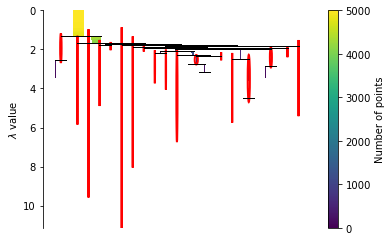

In [37]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=40)
clusterer.fit(u)
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('deep', 8))

In [38]:
colors = [str(x) for x in clusterer.labels_]

fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    color=colors,
    hover_name=titles[:n],
    )
fig.show()


In [50]:
# Initialisation du modèle BERTopic


# SUBSET FOR TESTING
#n = 10000
n = len(titles)

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stop_words = stopwords.words('french')

embedding_model = SentenceTransformer("dangvantuan/sentence-camembert-large")
clustering_model = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=50, prediction_data=True)
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.001, n_components=5, random_state=42)
vectorizer_model = CountVectorizer(stop_words=stop_words, ngram_range=(1, 2))

topic_model = BERTopic(
    verbose=True,
    calculate_probabilities=True,
    top_n_words=10,
    nr_topics=20,
    min_topic_size=20,
    embedding_model=embedding_model,
    hdbscan_model=clustering_model,
    umap_model=umap_model,
    vectorizer_model=vectorizer_model
)

No sentence-transformers model found with name C:\Users\renar/.cache\torch\sentence_transformers\dangvantuan_sentence-camembert-large. Creating a new one with MEAN pooling.


In [51]:
# Entrainement du modèle
topics, probs = topic_model.fit_transform(titles[:n])

Batches:   0%|          | 0/1350 [00:00<?, ?it/s]

2022-12-14 16:35:31,973 - BERTopic - Transformed documents to Embeddings
2022-12-14 16:36:14,315 - BERTopic - Reduced dimensionality
2022-12-14 16:36:24,099 - BERTopic - Clustered reduced embeddings
2022-12-14 16:36:28,889 - BERTopic - Reduced number of topics from 35 to 21


In [52]:
topic_model.visualize_topics()

In [53]:
topic_model.visualize_barchart(top_n_topics=20, n_words=10)

In [54]:
# plot the number of articles per topic using plotly
plot_data = topic_model.get_topic_info()

# print the number of articles for topic -1 (outliers)
print('Number of articles for topic -1 (outliers): ', plot_data['Count'][0])

fig = px.bar(
    plot_data[1:],
    x="Count",
    y="Name",
    title='Number of articles per topic',
    labels={'Count':'Number of articles', 'Topic':'Topic'}
)
# give the plot a nice layout
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

Number of articles for topic -1 (outliers):  13136
